In [25]:
import os
import sys
import glob
import h5py
import zipfile
import numpy as np
import tensorflow as tf
import keras
from time import time
from datetime import timezone, datetime
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Conv1D, SeparableConv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Layer
from keras.layers import ReLU, Softmax
from keras.layers import Lambda, Dot, Concatenate
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import Zeros, Constant
from keras.regularizers import L2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras import backend as K


from google.colab import drive

print(f'TF_VERSION={tf.__version__}')

TF_VERSION=2.3.0


In [4]:
# Hyperparameters

NUM_POINTS = 4096
NUM_CLASSES = 13
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE=1e-3
LR_DECAY_STEPS = 7000
LR_DECAY_RATE = 0.7

BASE_PATH='/content/gdrive/My Drive/Thesis/'

In [5]:
drive.mount('/content/gdrive')

zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Thesis/datasets/vkitti3d_h5.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

Mounted at /content/gdrive


In [6]:
train_data = []
train_label = []

files = glob.glob('/content/dataset/*')

for file in files:
    f = h5py.File(file, 'r')
    train_data.append(f['normalized_points'][:, :, 0:3])
    train_label.append(f['labels'])

train_data = np.concatenate(train_data, axis=0)
train_label = np.concatenate(train_label, axis=0)

train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=0.4, random_state=42)
val_data, test_data, val_label, test_label = train_test_split(val_data, val_label, test_size=0.5, random_state=42)

print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)
print(test_data.shape, test_label.shape)

(5058, 4096, 3) (5058, 4096)
(1686, 4096, 3) (1686, 4096)
(1686, 4096, 3) (1686, 4096)


In [7]:
def rotate(points):
    theta = np.random.uniform((-np.pi / 8, np.pi / 8))
    rotation_matrix = tf.stack([[tf.cos(theta), tf.sin(theta), 0],
                                   [-tf.sin(theta), tf.cos(theta), 0],
                                   [0, 0, 1]])
    return tf.matmul(points, tf.cast(rotation_matrix, dtype=tf.float32))

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
    # shuffle points
    #points = tf.random.shuffle(points)
    return points, label

one_hot_train_label = np_utils.to_categorical(train_label, NUM_CLASSES)
one_hot_val_label = np_utils.to_categorical(val_label, NUM_CLASSES)
one_hot_test_label = np_utils.to_categorical(test_label, NUM_CLASSES)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, one_hot_train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, one_hot_val_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, one_hot_test_label))

#train_dataset = train_dataset.shuffle(len(train_data)).map(augment).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.repeat(6).shuffle(len(train_data)).map(augment).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.repeat(6).shuffle(len(val_data)).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.repeat(6).shuffle(len(test_data)).batch(BATCH_SIZE, drop_remainder=True)

In [9]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2_reg=0.001):
        self.num_features = num_features
        self.l2_reg = l2_reg
        self.eye = tf.eye(num_features)

    def __call__(self, input):
        input = tf.reshape(input, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(input, input, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2_reg * tf.square(xxt - self.eye))

    #  Enable serialization
    def get_config(self):
        return {
            'num_features': self.num_features,
            'l2_reg': self.l2_reg
        }
    
    # Enable deserialization
    def from_config(cls, config):
        return cls(**config)

In [14]:
class TNet(Layer):
    def __init__(self, add_regularization=False, bn_momentum=0.99, **kwargs):
        super(TNet, self).__init__(**kwargs)
        self.add_regularization = add_regularization
        self.bn_momentum = bn_momentum
        self.conv0 = ConvLayer(16, 1, strides=1, bn_momentum=bn_momentum)
        self.conv1 = ConvLayer(32, 1, strides=1, bn_momentum=bn_momentum)
        #self.conv2 = ConvLayer(512, 1, strides=1, bn_momentum=bn_momentum)
        self.conv2 = ConvLayer(256, 1, strides=1, bn_momentum=bn_momentum)
        self.fc0 = DenseLayer(128, activation=tf.nn.relu, apply_bn=True, bn_momentum=bn_momentum)
        self.fc1 = DenseLayer(64, activation=tf.nn.relu, apply_bn=True, bn_momentum=bn_momentum)

    def build(self, input_shape):
        self.K = input_shape[-1]

        self.w = self.add_weight(shape=(64, self.K**2), initializer=tf.zeros_initializer,
                                 trainable=True, name='w')
        self.b = self.add_weight(shape=(self.K, self.K), initializer=tf.zeros_initializer,
                                 trainable=True, name='b')

        # Initialize bias with identity
        I = tf.constant(np.eye(self.K), dtype=tf.float32)
        self.b = tf.math.add(self.b, I)

    def call(self, x, training=None):
        input_x = x                                                     # BxNxK

        # Embed to higher dim
        x = tf.expand_dims(input_x, axis=2)                             # BxNx1xK
        x = self.conv0(x, training=training)
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        x = tf.squeeze(x, axis=2)                                       # BxNx1024

        # Global features
        x = tf.reduce_max(x, axis=1)                                    # Bx1024

        # Fully-connected layers
        x = self.fc0(x, training=training)                              # Bx512
        x = self.fc1(x, training=training)                              # Bx256

        # Convert to KxK matrix to matmul with input
        x = tf.expand_dims(x, axis=1)                                   # Bx1x256
        x = tf.matmul(x, self.w)                                        # Bx1xK^2
        x = tf.squeeze(x, axis=1)
        x = tf.reshape(x, (-1, self.K, self.K))

        # Add bias term (initialized to identity matrix)
        x += self.b

        # Add regularization
        if self.add_regularization:
            eye = tf.constant(np.eye(self.K), dtype=tf.float32)
            x_xT = tf.matmul(x, tf.transpose(x, perm=[0, 2, 1]))
            reg_loss = tf.nn.l2_loss(eye - x_xT)
            self.add_loss(1e-3 * reg_loss)

        return tf.matmul(input_x, x)

    def get_config(self):
        config = super(TNet, self).get_config()
        config.update({
            'add_regularization': self.add_regularization,
            'bn_momentum': self.bn_momentum})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class ConvLayer(Layer):
    def __init__(self, filters, kernel_size, strides, padding='valid', activation=None,
                 apply_bn=False, bn_momentum=0.99, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.apply_bn = apply_bn
        self.bn_momentum = bn_momentum
        self.conv = Conv1D(filters, kernel_size, strides=strides, padding=padding,
                           activation=activation, use_bias=not apply_bn)
        if apply_bn:
            self.bn = BatchNormalization(momentum=bn_momentum, fused=False)

    def call(self, x, training=None):
        x = self.conv(x)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(ConvLayer, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'activation': self.activation,
            'apply_bn': self.apply_bn,
            'bn_momentum': self.bn_momentum})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class DenseLayer(Layer):
    def __init__(self, units, activation=None, apply_bn=False, bn_momentum=0.99, **kwargs):
        super(DenseLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.apply_bn = apply_bn
        self.bn_momentum = bn_momentum
        self.dense = Dense(units, activation=activation, use_bias=not apply_bn)
        if apply_bn:
            self.bn = BatchNormalization(momentum=bn_momentum, fused=False)

    def call(self, x, training=None):
        x = self.dense(x)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(DenseLayer, self).get_config()
        config.update({
            'units': self.units,
            'activation': self.activation,
            'apply_bn': self.apply_bn,
            'bn_momentum': self.bn_momentum})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def get_model(num_points, num_classes, bn_momentum=.99):
    pt_cloud = Input(shape=(num_points, 3), dtype=tf.float32, name='pt_cloud')    # BxNx3

    # Input transformer (B x N x 3 -> B x N x 3)
    pt_cloud_transform = TNet(bn_momentum=bn_momentum)(pt_cloud)

    # Embed to 64-dim space (B x N x 3 -> B x N x 32)
    pt_cloud_transform = tf.expand_dims(pt_cloud_transform, axis=2)         # for weight-sharing of conv
    hidden_32 = ConvLayer(32, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                           bn_momentum=bn_momentum)(pt_cloud_transform)
    embed_32 = ConvLayer(32, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                          bn_momentum=bn_momentum)(hidden_32)
    embed_32 = tf.squeeze(embed_32, axis=2)

    # Feature transformer (B x N x 32 -> B x N x 32)
    embed_32_transform_t = TNet(bn_momentum=bn_momentum, add_regularization=True)(embed_32)

    # Embed to 256-dim space (B x N x 32 -> B x N x 256)
    embed_32_transform = tf.expand_dims(embed_32_transform_t, axis=2)
    hidden_32 = ConvLayer(32, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                           bn_momentum=bn_momentum)(embed_32_transform)
    hidden_64 = ConvLayer(64, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                            bn_momentum=bn_momentum)(hidden_32)
    #embed_1024 = ConvLayer(512, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
    #                        bn_momentum=bn_momentum)(hidden_128)
    embed_256 = ConvLayer(256, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                            bn_momentum=bn_momentum)(hidden_64)
    embed_256 = tf.squeeze(embed_256, axis=2)

    # Global feature vector (B x N x 256 -> B x 256)
    global_descriptor = tf.reduce_max(embed_256, axis=1)

    global_descriptor = tf.expand_dims(global_descriptor, axis=1)

    global_descriptor = tf.tile(global_descriptor, [1, num_points, 1])

    # Segmentation block
    concatenate = Concatenate()([embed_32_transform_t, global_descriptor])

    hidden_128 = ConvLayer(128, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                           bn_momentum=bn_momentum)(concatenate)

    hidden_128 = Dropout(rate=0.5)(hidden_128)

    hidden_64 = ConvLayer(64, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                            bn_momentum=bn_momentum)(hidden_128)

    hidden_64 = Dropout(rate=0.5)(hidden_64)
    
    embed_32 = ConvLayer(32, 1, strides=1, activation=tf.nn.relu, apply_bn=True,
                            bn_momentum=bn_momentum)(hidden_64)

    segmentation_output = Conv1D(filters=num_classes, kernel_size=1, strides=1, padding='valid')(embed_32)

    logits = Softmax()(segmentation_output)

    return Model(inputs=pt_cloud, outputs=logits, name='TinyPointNet_TF2-VKITTI3D')

In [40]:
model = get_model(num_points=NUM_POINTS, num_classes=NUM_CLASSES)

print(model.summary())

metrics = [
           'accuracy',
           tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
]

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.categorical_crossentropy,
              #loss=anchor_loss,
              metrics=metrics)

Model: "TinyPointNet_TF2-VKITTI3D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_cloud (InputLayer)           [(None, 4096, 3)]    0                                            
__________________________________________________________________________________________________
t_net_24 (TNet)                 (None, 4096, 3)      51360       pt_cloud[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_36 (Tens [(None, 4096, 1, 3)] 0           t_net_24[0][0]                   
__________________________________________________________________________________________________
conv_layer_168 (ConvLayer)      (None, 4096, 1, 32)  224         tf_op_layer_ExpandDims_36[0][0]  
__________________________________________________________________________

In [41]:
def decay_schedule(epoch, lr):
    # decay LR every 10 epochs
    if (epoch % 10 == 0) and (epoch != 0):
        lr = lr / 2
        print(f'Scheduled learning rate: {lr} on epoch {epoch}')
    return lr

checkpoint = ModelCheckpoint(
    filepath=BASE_PATH + 'TinyPointNet/Weights/TinyPointNet-weights-VKITTI3D-2020-11-30-epoch_{epoch:02d}-loss_{loss:.4f}-accuracy_{accuracy:.4f}.hdf5',
    monitor='loss',
    verbose=1,
    save_best_only=True
)

earlystopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0,
    verbose=1
)
    
lr_scheduler = LearningRateScheduler(decay_schedule, verbose=1)

tensorboard = TensorBoard(log_dir=BASE_PATH + 'TinyPointNet/Logs/2020-11-30-tiny-pointnet-vkitti3d')

callbacks = [checkpoint, earlystopping, reduce_lr, lr_scheduler, tensorboard]

In [42]:
history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks,
                    shuffle=True)

model.save(BASE_PATH + 'TinyPointNet/TinyPointNet_keras-VKITTI3D-2020-11-30')
model.save_weights(BASE_PATH + 'TinyPointNet/Weights/TinyPointNet-weights-final-VKITTI3D-2020-11-30.hdf5')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/100
474/474 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.5771 - mean_io_u_10: 0.4617
Epoch 00001: loss improved from inf to 1.35443, saving model to /content/gdrive/My Drive/Thesis/TinyPointNet/Weights/TinyPointNet-weights-VKITTI3D-2020-11-30-epoch_01-loss_1.354-accuracy_0.577.hdf5
474/474 [==============================] - 297s 627ms/step - loss: 1.3544 - accuracy: 0.5771 - mean_io_u_10: 0.4617 - val_loss: 2.2774 - val_accuracy: 0.2172 - val_mean_io_u_10: 0.4615

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/100
474/474 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.8134 - mean_io_u_10: 0.4624
Epoch 00002: loss improved from 1.35443 to 0.61974, saving model to /content/gdrive/My Drive/Thesis/TinyPointNet/Weights/TinyPointNet-weights-VKITTI3D-2020-11-30-epoch_02-loss_0.620-accuracy_0.813.hdf5
474/4

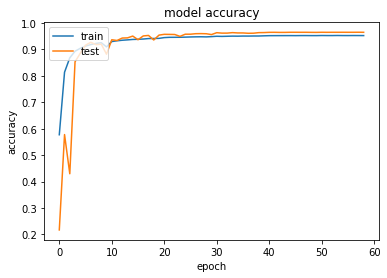

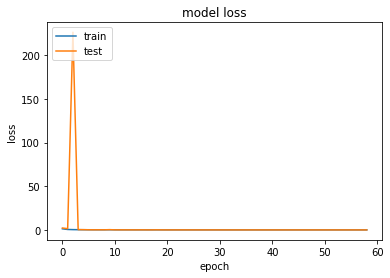

In [43]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
loss, acc, _ = model.evaluate(test_data, one_hot_test_label)
print(f'Test loss: {loss}')
print(f'Test accuracy: {acc}')

53/53 [==============================] - 3s 54ms/step - loss: 0.0997 - accuracy: 0.9647 - mean_io_u_10: 0.4884
Test loss: 0.09967906773090363
Test accuracy: 0.9646637439727783


In [45]:
for filename in files:
    f = h5py.File(filename, 'r')

    points = f['points']
    norm_points = f['normalized_points']
    labels = f['labels']

    data = norm_points[:, :, 0:3]

    predictions = model.predict(data)
    
    print(f'file: {filename} - shape: {predictions.shape}')

    pred_filename = BASE_PATH + 'TinyPointNet/Predictions-VKITTI3D/' + 'predictions_' + filename.split("/")[-1]

    pf = h5py.File(pred_filename, 'w')
    pf.create_dataset('points', data=points, compression='gzip', dtype='float32')
    pf.create_dataset('normalized_points', data=norm_points, compression='gzip', dtype='float32')
    pf.create_dataset('predicted_points', data=predictions, compression='gzip', dtype='float32')
    pf.create_dataset('labels', data=labels, compression='gzip', dtype='int64')

file: /content/dataset/vkitti3d_h5_v10018_00250.h5 - shape: (104, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10018_00140.h5 - shape: (102, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10001_00121.h5 - shape: (106, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10002_00143.h5 - shape: (86, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10002_00079.h5 - shape: (85, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10020_00418.h5 - shape: (87, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10020_00671.h5 - shape: (107, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10020_00210.h5 - shape: (84, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10002_00223.h5 - shape: (86, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10001_00145.h5 - shape: (99, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10001_00406.h5 - shape: (91, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10020_00288.h5 - shape: (87, 4096, 13)
file: /content/dataset/vkitti3d_h5_v10020_00262.h5 - shape: (84, 4096, 13)
file: /content/datase

In [52]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

logdir = '/content/gdrive/My Drive/Thesis/TinyPointNet/Logs/2020-11-30-tiny-pointnet-vkitti3d'

!ls '/content/gdrive/My Drive/Thesis/TinyPointNet/Logs/2020-11-30-tiny-pointnet-vkitti3d'

%tensorboard --logdir '/content/gdrive/My Drive/Thesis/TinyPointNet/Logs/2020-11-30-tiny-pointnet-vkitti3d'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
train  validation


Reusing TensorBoard on port 6007 (pid 2383), started 0:11:41 ago. (Use '!kill 2383' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
def anchor_loss(y_true, y_pred, gamma=0.5):
    pred_prob = tf.math.sigmoid(y_pred)

    # Obtain probabilities at indices of true class
    true_mask = tf.dtypes.cast(y_true, dtype=tf.bool)
    q_star = tf.boolean_mask(pred_prob, true_mask)
    q_star = tf.expand_dims(q_star, axis=1)

    # Calculate bce and add anchor loss coeff where labels equal 0
    loss_bce = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred)
    M = 1.0 - y_true
    loss_calc = (M * (1.0 + pred_prob - q_star + 0.05)**gamma + (1.0 - M)) * loss_bce

    return tf.math.reduce_mean(loss_calc)


In [ ]:
# Create model
def get_bn_momentum(step):
    return min(0.99, 0.5 + 0.0002*step)

print('Creating PointNet model...')

bn_momentum = tf.Variable(get_bn_momentum(0), trainable=False, name='momentum')
print(bn_momentum)
model = get_model(num_points=NUM_POINTS, num_classes=NUM_CLASSES, bn_momentum=bn_momentum)

print('Done!')

model.summary()

In [ ]:
# Instantiate optimizer and loss function
def get_lr(initial_learning_rate, decay_steps, decay_rate, step, staircase=False, warm_up=True):
    if warm_up:
        coeff1 = min(1.0, step/2000)
    else:
        coeff1 = 1.0

    if staircase:
        coeff2 = decay_rate ** (step // decay_steps)
    else:
        coeff2 = decay_rate ** (step / decay_steps)

    current = initial_learning_rate * coeff1 * coeff2
    return current
LR_ARGS = {'initial_learning_rate': LEARNING_RATE, 'decay_steps': LR_DECAY_STEPS,
           'decay_rate': LR_DECAY_RATE, 'staircase': False, 'warm_up': True}
lr = tf.Variable(get_lr(**LR_ARGS, step=0), trainable=False, name='learning_rate')
print(lr)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fxn = tf.keras.losses.categorical_crossentropy


# Instantiate metric objects
train_acc = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
train_prec = tf.keras.metrics.Precision()
train_recall = tf.keras.metrics.Recall()
val_acc = tf.keras.metrics.CategoricalAccuracy()
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
val_prec = tf.keras.metrics.Precision()
val_recall = tf.keras.metrics.Recall()

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0>


In [ ]:
# Training
print('Training...')
print(f'Steps per epoch = {len(train_data) // BATCH_SIZE}')
print(f'Total steps = {(len(train_data) // BATCH_SIZE) * EPOCHS}')

@tf.function
def train_step(inputs, labels):
    # Forward pass with gradient tape and loss calc
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss = loss_fxn(labels, logits) + sum(model.losses)

    # Obtain gradients of trainable vars w.r.t. loss and perform update
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return logits, loss, model.losses[0]


current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir_base = BASE_PATH + '/logs/pointnet-tf2/'
train_log_dir = log_dir_base + current_time + '/train'
test_log_dir = log_dir_base + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_base)
tensorboard_callback.set_model(model)


@tf.function
def val_step(inputs, labels):
    logits = model(inputs, training=False)
    loss = loss_fxn(labels, logits)
    return logits, loss

step = 0
for epoch in range(EPOCHS):
    # print(f'Epoch: {epoch}')

    # Reset metrics
    train_acc.reset_states()
    train_loss.reset_states()
    train_prec.reset_states()
    train_recall.reset_states()
    val_acc.reset_states()
    val_loss.reset_states()
    val_prec.reset_states()
    val_recall.reset_states()

    # Train on batches
    for x_train, y_train in train_dataset:
        tic = time()

        logits, loss, mat_reg_loss = train_step(x_train, y_train)

        train_probs = tf.math.sigmoid(logits)
        train_acc.update_state(y_train, train_probs)
        train_loss.update_state(loss)

        max_idxs = tf.math.argmax(train_probs, axis=2)
        train_one_hot = tf.one_hot(max_idxs, depth=NUM_CLASSES, dtype=tf.float32)
        train_prec.update_state(y_train, train_one_hot)
        train_recall.update_state(y_train, train_one_hot)

        '''
        print(f'time_per_step: {time() - tic}')
        print(f'learning_rate: {lr.numpy()}')
        print(f'training_loss: {train_loss.numpy()}')
        print(f'mat_reg_loss: {mat_reg_loss.numpy()}')
        print(f'bn_momentum: {bn_momentum.numpy()}')
        '''
        
        step += 1
        bn_momentum.assign(get_bn_momentum(step))
        lr.assign(get_lr(**LR_ARGS, step=step))
    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    # Run validation at the end of epoch
    for x_val, y_val in test_dataset:
        logits, loss = val_step(x_val, y_val)

        val_probs = tf.math.sigmoid(logits)
        val_acc.update_state(y_val, val_probs)
        val_loss.update_state(loss)

        max_idxs = tf.math.argmax(val_probs, axis=2)
        val_one_hot = tf.one_hot(max_idxs, depth=NUM_CLASSES, dtype=tf.float32)
        val_prec.update_state(y_val, val_one_hot)
        val_recall.update_state(y_val, val_one_hot)

    with test_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', val_acc.result(), step=epoch)

    # Save every epoch (.save_weights() since bn_momentum instance isn't serializable)
    print(f'Save weights at step {step}')
    model.save_weights(BASE_PATH + f'weights/pointnet-tf2-weights-SIS3D-epoch-{epoch}-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}', save_format='h5')

    #print(f'train accuracy: {train_acc.result().numpy()}')
    #print(f'train precision: {train_prec.result().numpy()}')
    #print(f'train recall: {train_recall.result().numpy()}')
    #print(f'val accuracy: {val_acc.result().numpy()}')
    #print(f'val precision: {val_prec.result().numpy()}')
    #print(f'val recall: {val_recall.result().numpy()}')

    print(f'Epoch: {epoch+1} - loss: {train_loss.result():.4f} accuracy: {train_acc.result():.4f} val_loss: {val_loss.result():.4f} val_accuracy: {val_acc.result():.4f}')

#print('Done training! Save model...')
#model.save(BASE_PATH + f'pointnet-tf2-model-SIS3D-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}-accuracy-{val_acc.result():.4f}', save_format='tf')
#print('Model saved successfully!')